### comienzo con el trabajo de escalado y muestreo de dataset

In [1]:
import sys
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# carga de datos
sys.path.append('D:\Proyectos Personales ML\Fraud detection\data\raw\creditcard.csv')
DATA_PATH = r'D:\Proyectos Personales ML\Fraud detection\data\raw\creditcard.csv'
df = pd.read_csv(DATA_PATH)

df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
df.shape

(284807, 31)

Resumen de Outliers:


,Variable,N_Outliers,Percentage,Lower_Bound,Upper_Bound
27,V27,39163,13.750715,-0.313667,0.333872
0,Amount,31904,11.201972,-101.747500,184.512500
28,V28,30342,10.653530,-0.249819,0.275140
20,V20,27770,9.750463,-0.728865,0.650184
8,V8,24134,8.473809,-1.012593,1.131309
6,V6,22965,8.063355,-2.518586,2.148856
23,V23,18541,6.510023,-0.626079,0.611875
12,V12,15348,5.388912,-1.941286,2.153952
21,V21,14497,5.090114,-0.850553,0.808535
14,V14,14149,4.967926,-1.803660,1.871236


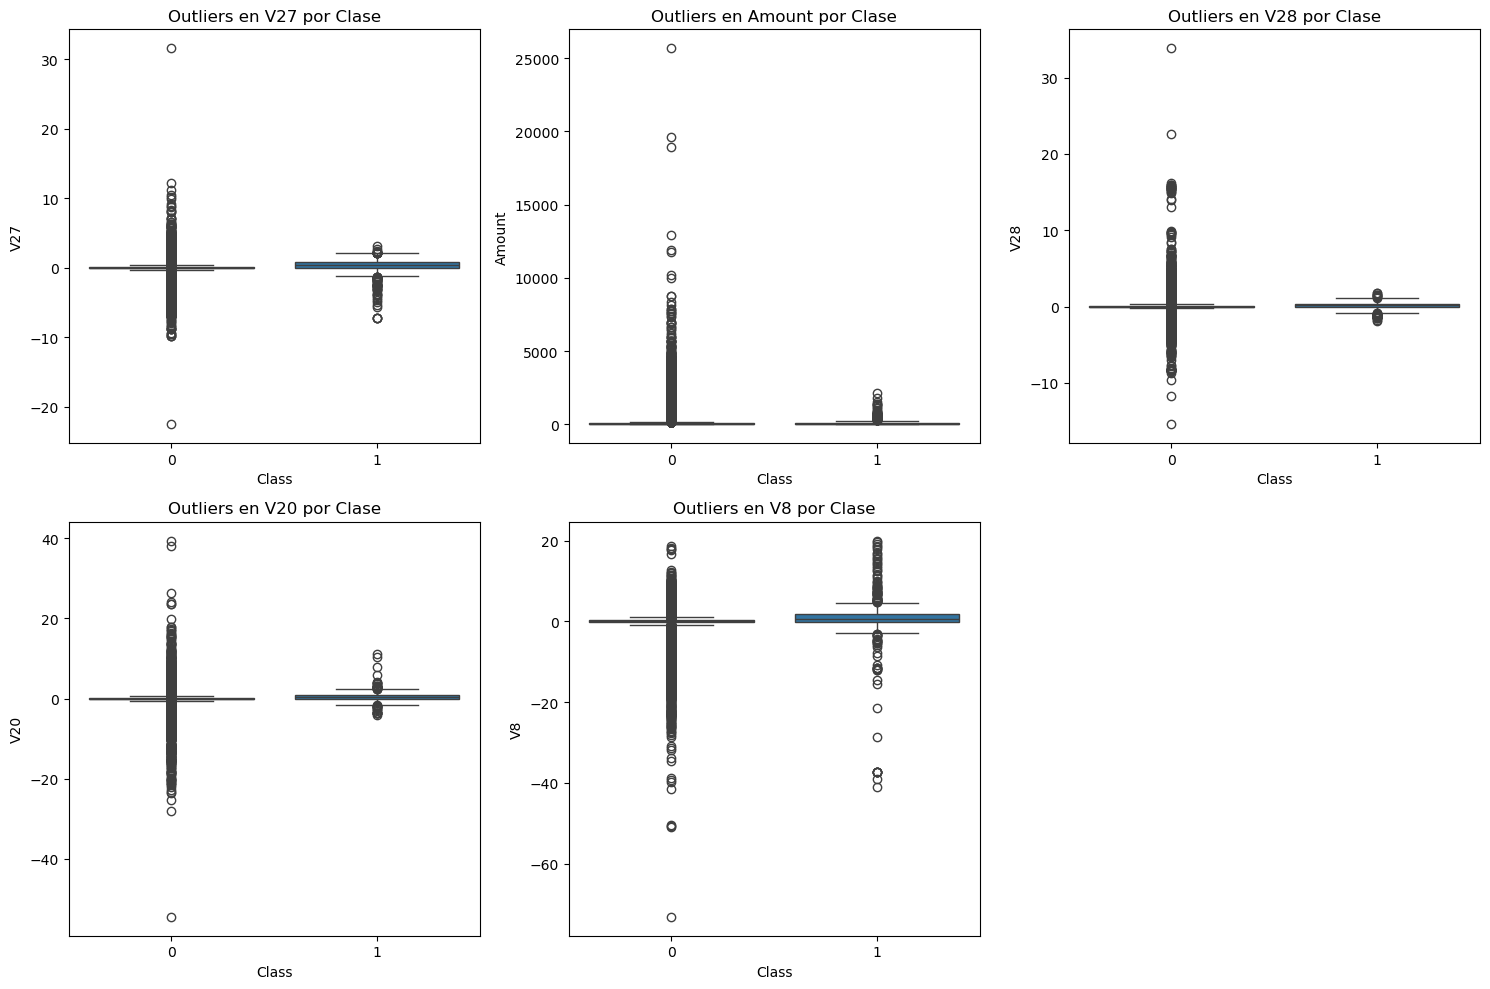

In [5]:
#analisis para deteccion de autliers
def detect_outliers(df,column):
    Q1= df[column].quantile(0.25)
    Q3= df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers), lower_bound, upper_bound
    
# analisis de outliers en Amount y V

variables_to_check= ['Amount'] +  [f'V{i}' for i in range(1, 29)] 

outliers_summary = []
for column in variables_to_check:
    n_outliers, lower, upper = detect_outliers(df, column)
    outliers_summary.append({
        'Variable': column,
        'N_Outliers': n_outliers,
        'Percentage': (n_outliers/len(df))*100,
        'Lower_Bound': lower,
        'Upper_Bound': upper
    })

# Mostrar resumen de outliers
outliers_df = pd.DataFrame(outliers_summary)
print("Resumen de Outliers:")
display(outliers_df.sort_values('Percentage', ascending=False).head(10))

# Visualizar distribución de outliers para Amount y top 5 variables con más outliers
top_vars = outliers_df.nlargest(5, 'Percentage')['Variable'].tolist()

plt.figure(figsize=(15, 10))
for i, var in enumerate(top_vars, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Class', y=var, data=df)
    plt.title(f'Outliers en {var} por Clase')

plt.tight_layout()
plt.show()


Distribución actual de clases:
Class
0    284315
1       492
Name: count, dtype: int64

Porcentajes:
Class
0    99.827251
1     0.172749
Name: count, dtype: float64


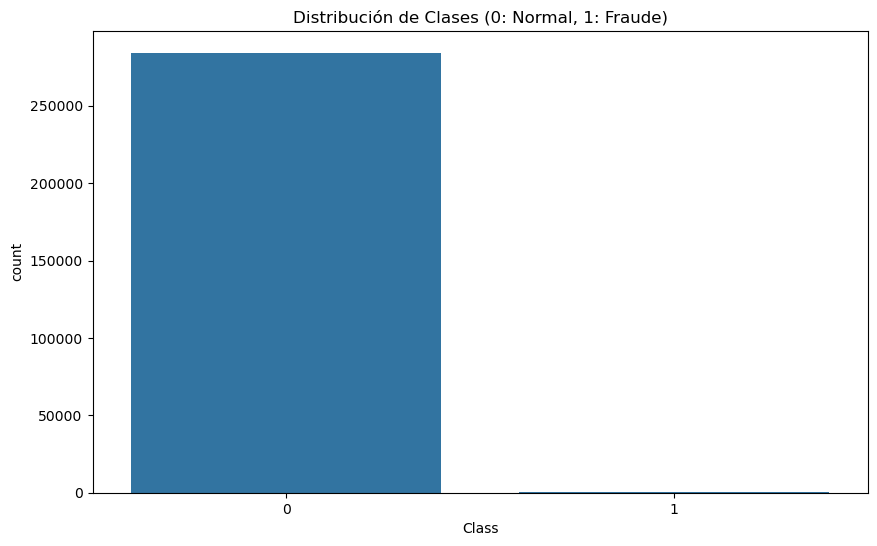

In [6]:
# Mostrar el desbalance actual
print("\nDistribución actual de clases:")
class_counts = df['Class'].value_counts()
print(class_counts)
print("\nPorcentajes:")
print(class_counts/len(df)*100)

# Visualizar el desbalance
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Class')
plt.title('Distribución de Clases (0: Normal, 1: Fraude)')
plt.show()

In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Separar características y variable objetivo
X = df.drop('Class', axis=1)
y = df['Class']

# Estrategia 1: SMOTE + Undersampling
sampling_strategy = 0.1  # Aumentar la clase minoritaria al 10% de la mayoritaria
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("\nDistribución después de SMOTE:")
print(Counter(y_smote))

# Aplicar undersampling después de SMOTE
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_balanced, y_balanced = rus.fit_resample(X_smote, y_smote)

print("\nDistribución final después de SMOTE + Undersampling:")
print(Counter(y_balanced))


Distribución después de SMOTE:
Counter({0: 284315, 1: 28431})

Distribución final después de SMOTE + Undersampling:
Counter({0: 56862, 1: 28431})


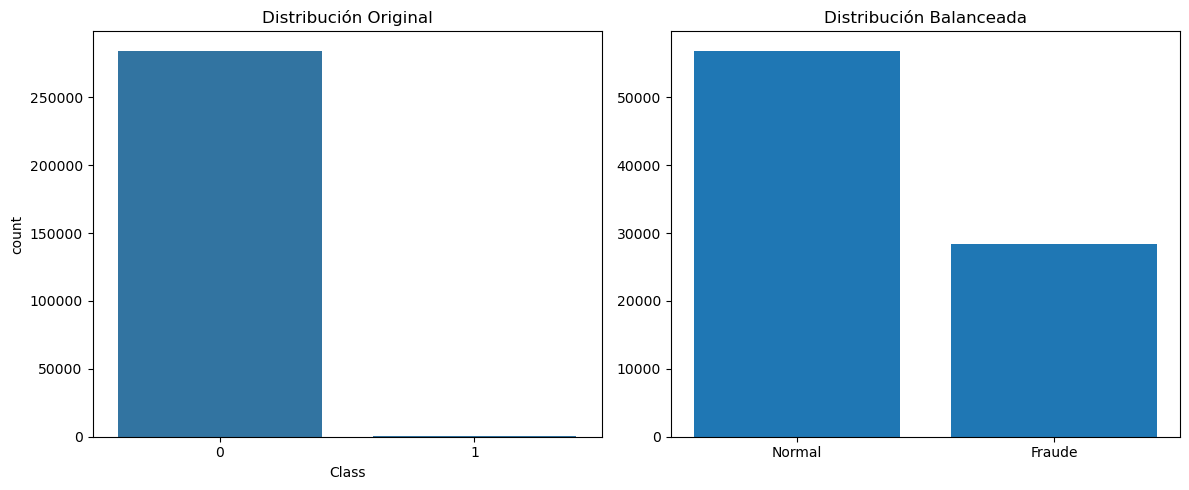

Distribución Original: Counter({0: 284315, 1: 492})
Distribución Balanceada: Counter({0: 56862, 1: 28431})


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Graficar distribución original vs balanceada
plt.figure(figsize=(12, 5))

# Distribución original
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Class')
plt.title('Distribución Original')

# Distribución después del balanceo
plt.subplot(1, 2, 2)
counter_balanced = Counter(y_balanced)
plt.bar(['Normal', 'Fraude'], [counter_balanced[0], counter_balanced[1]])
plt.title('Distribución Balanceada')

plt.tight_layout()
plt.show()

# Mostrar cantidades
print("Distribución Original:", Counter(y))
print("Distribución Balanceada:", counter_balanced)

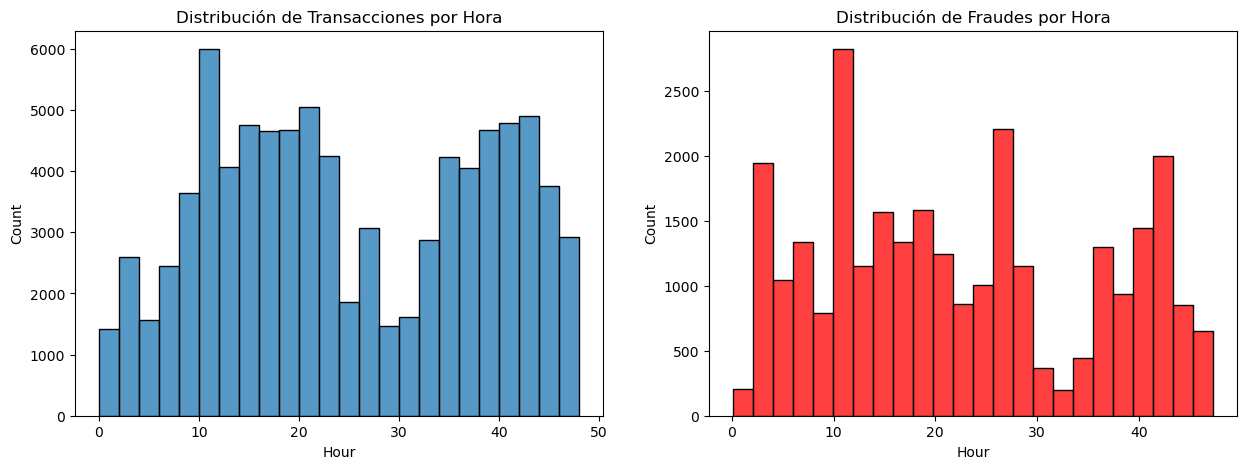

In [9]:
# Crear DataFrame con datos balanceados
df_balanced = pd.DataFrame(X_balanced, columns=X.columns)
df_balanced['Class'] = y_balanced
df_balanced['Hour'] = df_balanced['Time'] / 3600

# Visualizar
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_balanced, x='Hour', bins=24)
plt.title('Distribución de Transacciones por Hora')

plt.subplot(1, 2, 2)
sns.histplot(data=df_balanced[df_balanced['Class']==1], x='Hour', bins=24, color='red')
plt.title('Distribución de Fraudes por Hora')
plt.show()

In [10]:
df_balanced.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
138028,82450.0,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,-0.132137,...,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,0.76,0,22.902778
63099,50554.0,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,-0.760214,...,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901,4.18,0,14.042778
73411,55125.0,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,-2.628854,...,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582,15.00,0,15.312500
164247,116572.0,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,-0.149734,...,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330,57.00,0,32.381111
148999,90434.0,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,0.683491,...,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,0.00,0,25.120556


In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separar features y target
X = df_balanced.drop('Class', axis=1)
y = df_balanced['Class']

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modelo MLP
mlp = MLPClassifier(hidden_layer_sizes=(64, 32, 16), 
                  activation='relu',
                  solver='adam',
                  max_iter=100,
                  random_state=42)

# Entrenar
mlp.fit(X_train, y_train)

# Evaluar
print("Score en train:", mlp.score(X_train, y_train))
print("Score en test:", mlp.score(X_test, y_test))

Score en train: 0.9994724037869683
Score en test: 0.9979482970865818


### aqui podria quedarme directamente que estos resultados y ver cuales son las features mas importantes para el modelo


In [12]:

from sklearn.inspection import permutation_importance
#evaluar la importancia de caracteristicas con permutacion
result= permutation_importance(mlp, X_test, y_test, n_repeats= 110, random_state= 42)

#extraigo importancias
importancias = result.importances_mean

#ordenar las importancias
ranking =np.argsort(importancias)[::-1]

print('Importancia de caractericas (por permutacion)')
print('Ranking de importancias', ranking)

Importancia de caractericas (por permutacion)
Ranking de importancias [14 10  4 12  1  8 25  9 13 15  0  3 28 11 19  6 26  5 18 17 22 24 30  2
 20 16 29 21 23 27  7]


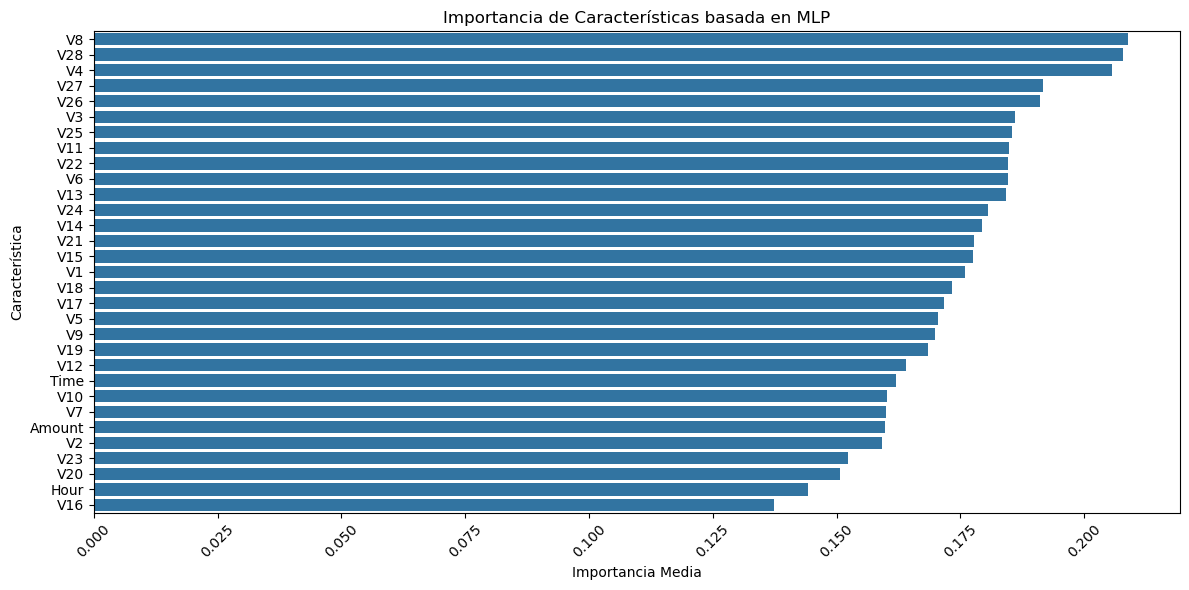


Top 10 características más importantes:
   feature  importance
8       V8    0.208884
28     V28    0.207739
4       V4    0.205672
27     V27    0.191746
26     V26    0.191001
3       V3    0.185963
25     V25    0.185387
11     V11    0.184797
22     V22    0.184543
6       V6    0.184535


In [13]:
# Obtener los coeficientes de la primera capa
importances = np.abs(mlp.coefs_[0]).mean(axis=1)

# Crear DataFrame con nombres de features e importancias
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

# Ordenar por importancia
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualización
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Importancia de Características basada en MLP')
plt.xlabel('Importancia Media')
plt.ylabel('Característica')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar top 10 características más importantes
print("\nTop 10 características más importantes:")
print(feature_importance.head(10))

C:\Users\leona\AppData\Local\Temp\ipykernel_19000\478976654.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='importance', y='feature', palette=colors)


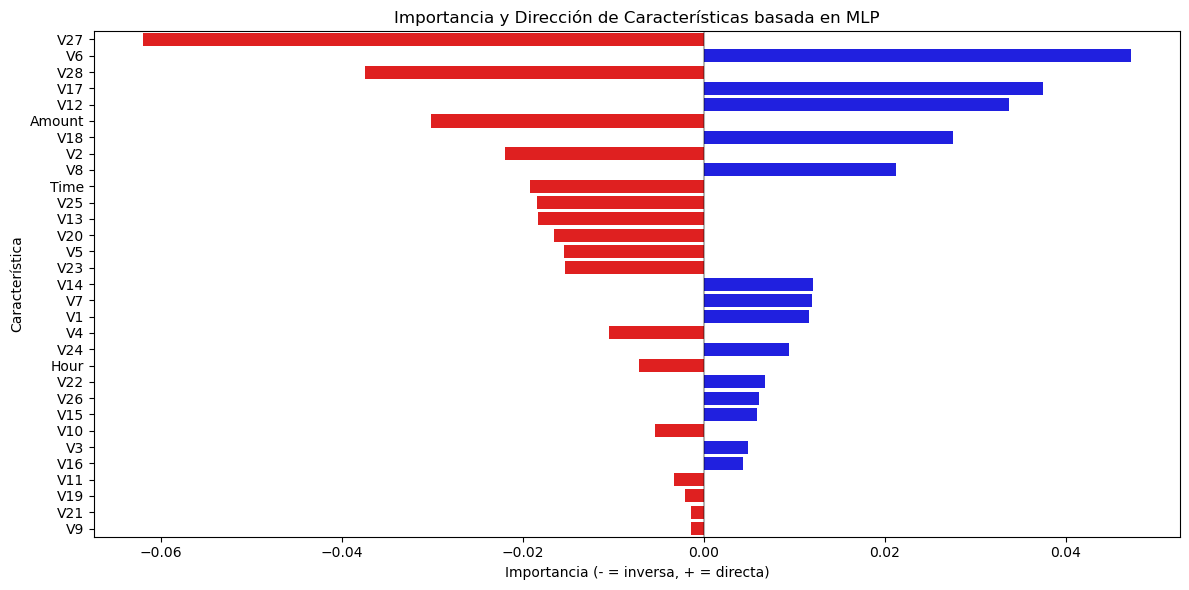


Top 5 características con influencia positiva (directa):
   feature  importance  abs_importance
6       V6    0.047198        0.047198
17     V17    0.037468        0.037468
12     V12    0.033785        0.033785
18     V18    0.027561        0.027561
8       V8    0.021307        0.021307

Top 5 características con influencia negativa (inversa):
   feature  importance  abs_importance
27     V27   -0.061980        0.061980
28     V28   -0.037479        0.037479
29  Amount   -0.030186        0.030186
2       V2   -0.022026        0.022026
0     Time   -0.019213        0.019213


In [14]:
# Obtener los coeficientes de la primera capa sin valor absoluto
importances = mlp.coefs_[0].mean(axis=1)

# Crear DataFrame con nombres de features e importancias
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

# Ordenar por valor absoluto de importancia para la visualización
feature_importance['abs_importance'] = np.abs(importances)
feature_importance = feature_importance.sort_values('abs_importance', ascending=False)

# Visualización
plt.figure(figsize=(12, 6))
# Usar diferentes colores para valores positivos y negativos
colors = ['red' if x < 0 else 'blue' for x in feature_importance['importance']]
sns.barplot(data=feature_importance, x='importance', y='feature', palette=colors)
plt.title('Importancia y Dirección de Características basada en MLP')
plt.xlabel('Importancia (- = inversa, + = directa)')
plt.ylabel('Característica')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar características más importantes separadas por influencia
print("\nTop 5 características con influencia positiva (directa):")
print(feature_importance[feature_importance['importance'] > 0].head())

print("\nTop 5 características con influencia negativa (inversa):")
print(feature_importance[feature_importance['importance'] < 0].head())

### Todos estos metodos que probamos y todos nos dieron diferentes las primeras 3, asi aqui podriamos combinarlos o elegir uno, en este caso elegiremos el metodo de permutacion ya que este metodo es independiente del modelo para las featrues importances

C:\Users\leona\AppData\Local\Temp\ipykernel_19000\4184179030.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='importance', y='feature',


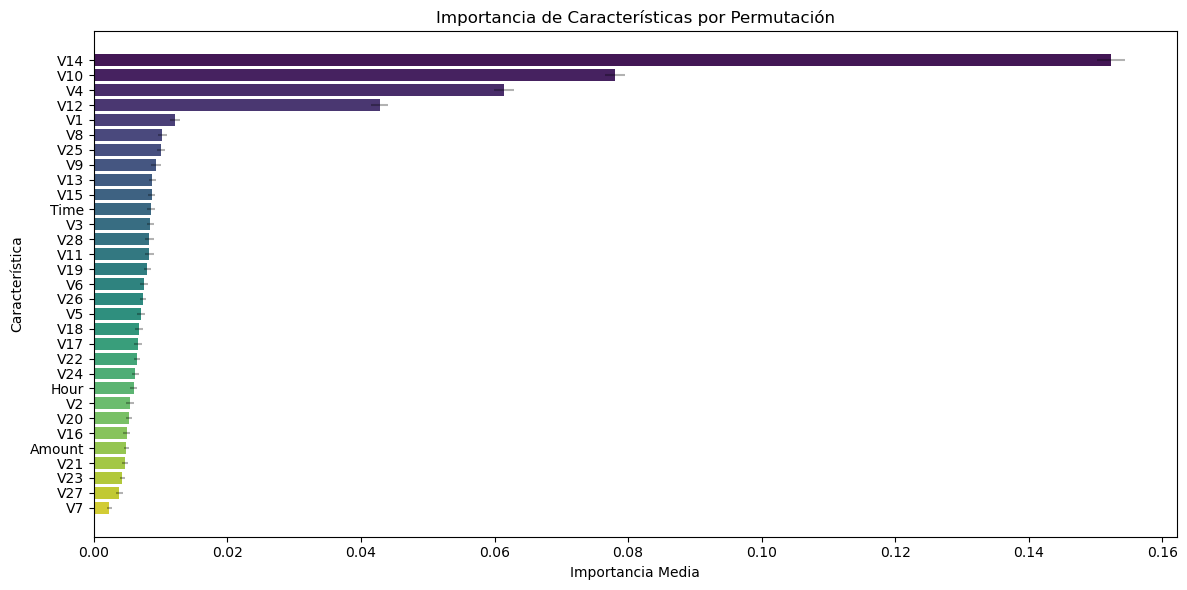

Top 10 características más importantes:
   feature  importance       std
14     V14    0.152299  0.002145
10     V10    0.078020  0.001541
4       V4    0.061417  0.001552
12     V12    0.042805  0.001275
1       V1    0.012171  0.000747
8       V8    0.010288  0.000699
25     V25    0.010018  0.000627
9       V9    0.009302  0.000714
13     V13    0.008764  0.000513
15     V15    0.008708  0.000521

Número de características seleccionadas: 4
Características seleccionadas: ['V14', 'V10', 'V4', 'V12']


In [16]:
from sklearn.inspection import permutation_importance

#calcular importancia por permutacion
perm_importance = permutation_importance(mlp, X_test, y_test, n_repeats= 10, random_state= 42)

#crear un dataframe de la permutacion para graficas
feature_importance= pd.DataFrame({
    "feature": X.columns,
    "importance": result['importances_mean'],
    "std": result['importances_std']
})

#ordenar las importances
feature_importance = feature_importance.sort_values('importance', ascending=False)

#Visualizacion y grafica
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', 
            palette='viridis')
plt.title('Importancia de Características por Permutación')
plt.xlabel('Importancia Media')
plt.ylabel('Característica')
plt.errorbar(x=feature_importance['importance'], 
            y=range(len(feature_importance)), 
            xerr=feature_importance['std'], 
            fmt='none', color='black', alpha=0.3)
plt.tight_layout()
plt.show()


# Mostrar resultados numéricos
print("Top 10 características más importantes:")
print(feature_importance.head(10))

# Podemos seleccionar las características más importantes
threshold = feature_importance['importance'].mean()
selected_features = feature_importance[feature_importance['importance'] > threshold]['feature'].tolist()

print("\nNúmero de características seleccionadas:", len(selected_features))
print("Características seleccionadas:", selected_features)

### Con este resultado obtendo las primeras 5 features aptas para correlacionar.Ahora vamos a ver si son positivas o negativas

C:\Users\leona\AppData\Local\Temp\ipykernel_19000\676437395.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='importance', y='feature', palette=colors)


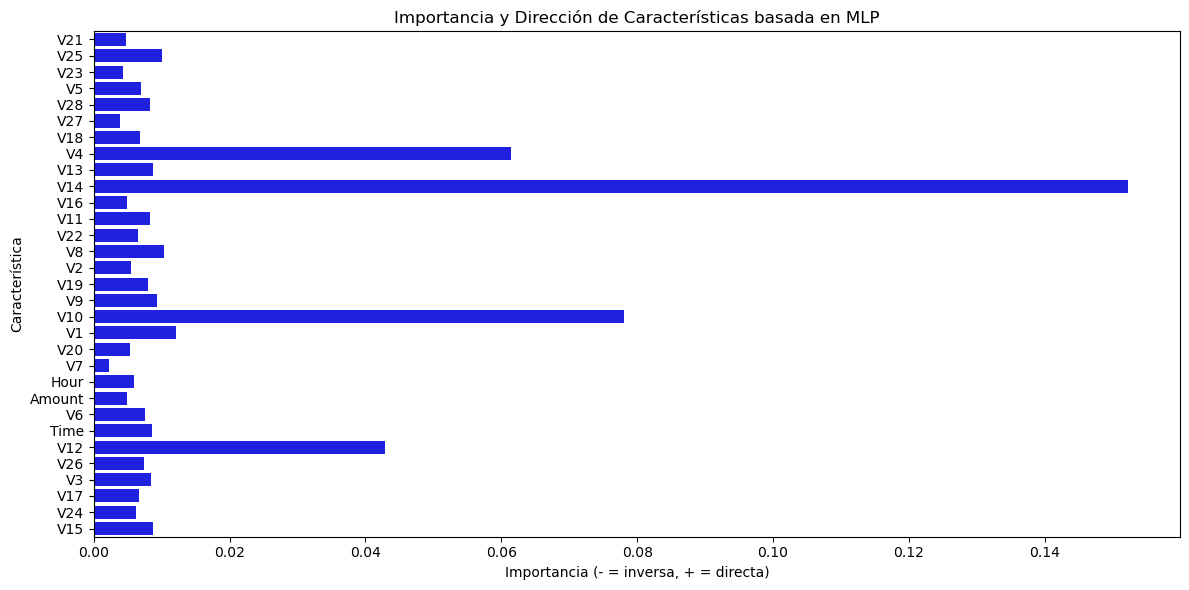


Top 5 características con influencia positiva (directa):
   feature  importance       std  abs_importance
21     V21    0.004687  0.000425        0.061980
25     V25    0.010018  0.000627        0.047198
23     V23    0.004298  0.000416        0.037479
5       V5    0.007017  0.000592        0.037468
28     V28    0.008332  0.000622        0.033785

Top 5 características con influencia negativa (inversa):
Empty DataFrame
Columns: [feature, importance, std, abs_importance]
Index: []


In [17]:
# Ordenar por valor absoluto de importancia para la visualización
feature_importance['abs_importance'] = np.abs(importances)
feature_importance = feature_importance.sort_values('abs_importance', ascending=False)

# Visualización
plt.figure(figsize=(12, 6))
# Usar diferentes colores para valores positivos y negativos
colors = ['red' if x < 0 else 'blue' for x in feature_importance['importance']]
sns.barplot(data=feature_importance, x='importance', y='feature', palette=colors)
plt.title('Importancia y Dirección de Características basada en MLP')
plt.xlabel('Importancia (- = inversa, + = directa)')
plt.ylabel('Característica')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar características más importantes separadas por influencia
print("\nTop 5 características con influencia positiva (directa):")
print(feature_importance[feature_importance['importance'] > 0].head())

print("\nTop 5 características con influencia negativa (inversa):")
print(feature_importance[feature_importance['importance'] < 0].head())

In [22]:
# Seleccionar las features más importantes
selected_features = ['V14', 'V10', 'V4', 'V12', 'V1']

X_selected= X[selected_features]

print('Dimensiones Originales', X.shape)
print("Dimensiones después de selección:", X_selected.shape)

Dimensiones Originales (85293, 31)
Dimensiones después de selección: (85293, 5)


In [25]:
from pathlib import Path

# Crear DataFrame final
selected_features = ['V14', 'V10', 'V4', 'V12', 'V1']
X_final = X[selected_features]
df_final = pd.concat([X_final, y], axis=1)

# Verificar el dataset final
print("Dimensiones del dataset final:", df_final.shape)
print("\nPrimeras filas del dataset final:")
print(df_final.head())

# Crear el directorio si no existe
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

# Guardar el dataset procesado
df_final.to_csv(output_dir / 'data_processed.csv', index=False)

Dimensiones del dataset final: (85293, 6)

Primeras filas del dataset final:
             V14       V10        V4       V12        V1  Class
138028 -1.054631 -0.597739  0.716564 -0.216435  1.314539      0
63099   0.573006  0.170547  0.694584  0.468322 -0.798672      0
73411  -0.338340  2.051312 -1.308725 -0.594037 -0.391128      0
164247 -0.436671 -1.238598 -0.029567 -0.586472 -0.060302      0
148999  1.323225  1.166335  3.866438 -1.920966  1.848433      0
